# Yunding lock all-in-one notebook

## Create dataset

This section reads the `aedat4` files and creates a folder of preprocessed train and test data.
You *do not need* to run this cell if you already have the dataset ready.

In [1]:
from aer4manager import aedatconvert

conv = aedatconvert(
    data_list_file='./file_list.txt',
    accumulation_method='spikecount',
    accumulation_value=3000,
    test_fraction=0.2,
    output_resolution=(64, 64),
    crop_size=((45, 45), (2, 2)),
    hot_pixel_frequency=0.001,
).to_folder(
    out_dir='data',
    overwrite=False,
    compressed=False,  # if True smaller files, but slower to read and write
)

Found 24 hot pixels
Removed 5546481 spikes from hot pixels


/home/martino/Work/AER4manager/aer4manager/convert_from_events.py:105: UserWarning: Reached maximum value for uint8. The result may be clipped.
  warn("Reached maximum value for uint8. The result may be clipped.")


Found 23 hot pixels
Removed 463691 spikes from hot pixels
Found 34 hot pixels
Removed 4095227 spikes from hot pixels
Found 29 hot pixels
Removed 5391861 spikes from hot pixels
Found 22 hot pixels
Removed 708531 spikes from hot pixels
Found 28 hot pixels
Removed 6600819 spikes from hot pixels
Found 23 hot pixels
Removed 1531532 spikes from hot pixels
Found 19 hot pixels
Removed 572126 spikes from hot pixels
Found 22 hot pixels
Removed 5042686 spikes from hot pixels
Found 25 hot pixels
Removed 880896 spikes from hot pixels
Found 22 hot pixels
Removed 827886 spikes from hot pixels
Found 30 hot pixels
Removed 3160673 spikes from hot pixels
Found 23 hot pixels
Removed 1658058 spikes from hot pixels
Found 22 hot pixels
Removed 2014392 spikes from hot pixels
Found 26 hot pixels
Removed 9374581 spikes from hot pixels
Found 23 hot pixels
Removed 759622 spikes from hot pixels
Found 31 hot pixels
Removed 4503704 spikes from hot pixels
Found 23 hot pixels
Removed 1180190 spikes from hot pixels
Fou

## Read dataset

#### Instantiate Dataset and Dataloader

In [13]:
from aer4manager import AERFolderDataset
import torchvision.transforms as ttr

# transforms for the training dataset
transforms = ttr.Compose([
    ttr.ToPILImage(),
#     ttr.RandomAffine(degrees=0, translate=(0, 0.2),
#                      scale=(0.9, 1.1), fillcolor=0),
#     ttr.RandomHorizontalFlip(),
    ttr.ToTensor()
])

transf_test = ttr.Compose([
    ttr.ToPILImage(),
    ttr.ToTensor()
])
        
train_dataset = AERFolderDataset(
    root='data/',
    from_spiketrain=False,
    transform=transforms,
    which='train'
)

test_dataset = AERFolderDataset(
    root='data/',
    from_spiketrain=False,
    transform=transf_test,
    which='test'
)

print("Number of training frames:", len(train_dataset))
print("Number of testing frames:", len(test_dataset))


Number of training frames: 10299
Number of testing frames: 2603


In [15]:
train_dataset[0][0].shape

torch.Size([1, 64, 64])

In [2]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Display examples

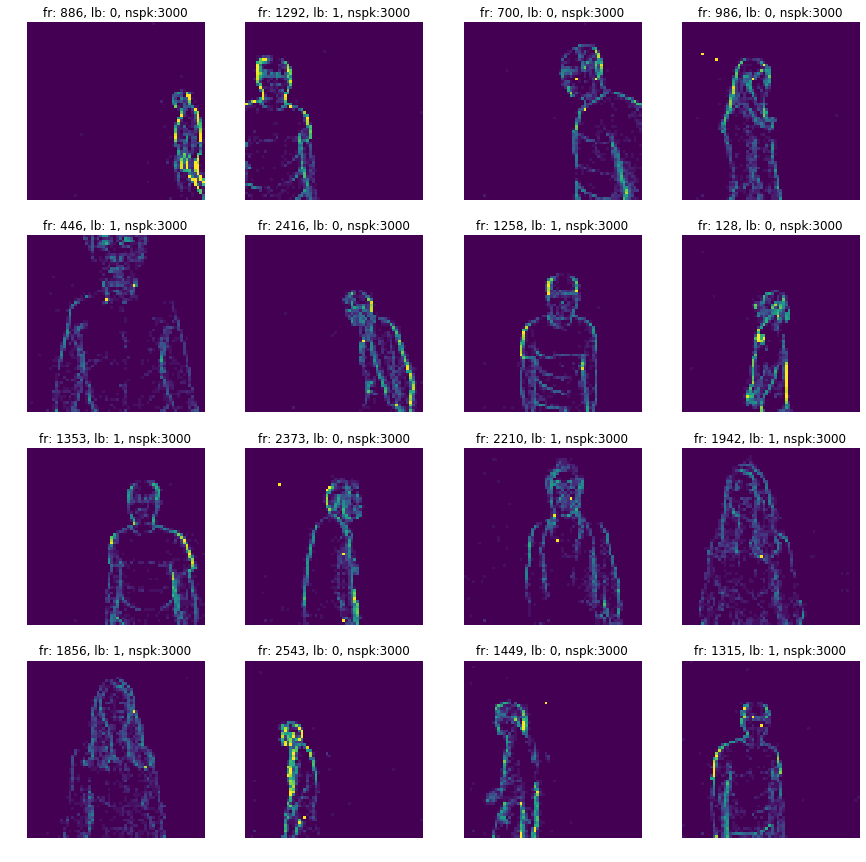

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.figure(figsize=(15, 15))
for i, idx in enumerate(np.random.choice(len(test_dataset), size=16)):
    image, label = test_dataset[idx]
    plt.subplot(4, 4, i+1)
    nspk = int(image.sum()*255)
    plt.title(f"fr: {idx}, lb: {label}, nspk:{nspk}")
    plt.imshow(image[0], vmin=0, vmax=0.1)
    plt.axis("off")
    if i==15: break

## Define the model

In [4]:
from torch.functional import F
import torch

class MyClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels= 8, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Conv2d(in_channels=8, out_channels= 12, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Conv2d(in_channels=12, out_channels= 12, kernel_size=(3,3), bias=False),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            torch.nn.Dropout2d(0.5),
            torch.nn.Flatten(),
            torch.nn.Linear(432, 128, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2, bias=False),
            torch.nn.ReLU(),
        )
        
    def forward(self, x):
        return self.seq(x)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define model and learning parameters
myclass = MyClassifier().to(device)
# Define loss
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer
optimizer = torch.optim.Adam(myclass.parameters(), lr = 1e-3)

RuntimeError: CUDA error: out of memory

In [58]:
hookable_modules = ['seq.1','seq.4','seq.7','seq.12','seq.14']

def hook(m, i, o):
    global activation
    activation += o.mean()

for name, module in myclass.named_modules():
    if name in hookable_modules:
        module.register_forward_hook(hook)
        print(name, module)

seq.1 ReLU()
seq.4 ReLU()
seq.7 ReLU()
seq.12 ReLU()
seq.14 ReLU()


In [85]:
# Impose Kaiming He initialization
for w in myclass.parameters():
    torch.nn.init.kaiming_uniform_(w, nonlinearity='relu')

In [87]:
from tqdm import tqdm_notebook as tqdm
from torch import nn

ACTIVATION_PENALTY = 0.3

n_epochs = 10
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    accuracy_train = []
    # Set to training mode
    myclass.train()
    running_loss = 0
    
    for batch_id, sample in enumerate(train_dataloader):
        imgs, labels = sample
        labels = labels.to(device)

        optimizer.zero_grad()
        activation = torch.cuda.FloatTensor([0])

        outputs = myclass(imgs.to(device))

        _, predicted = torch.max(outputs, 1)
        binary_labels = labels # torch.max(labels, 1)
        acc = (predicted == binary_labels.to(device)).sum().float()/len(labels)
        accuracy_train.append(acc.cpu().numpy())

        target_loss = criterion(outputs, labels)
        loss = target_loss + activation * ACTIVATION_PENALTY
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f"Activation {activation.item()}, Task loss {target_loss.item()}")
        
        
    # Test network accuracy
    with torch.no_grad():
        # Set to eval mode
        myclass.eval()
        
        accuracy = []
        for batch_id, sample in enumerate(test_dataloader):
            test_data, test_labels = sample
            outputs = myclass(test_data.to(device))
                        
            _, predicted = torch.max(outputs, 1)
            test_bin_labels = test_labels # torch.max(test_labels, 1)
            
            acc =(predicted==test_bin_labels.to(device)).sum().float()/len(test_labels)
            accuracy.append(acc.cpu().numpy())
        accuracy = np.mean(accuracy)
    accuracy_train = np.mean(accuracy_train)
        
    pbar.set_postfix(loss=running_loss, epoch=epoch, accuracy_test=accuracy, accuracy_train=accuracy_train)

Activation 0.31205683946609497, Task loss 0.5255607962608337
Activation 0.38632720708847046, Task loss 0.5450698733329773
Activation 0.46850287914276123, Task loss 0.49971699714660645
Activation 0.43060481548309326, Task loss 0.4351351857185364
Activation 0.4103267788887024, Task loss 0.5756016969680786
Activation 0.49149075150489807, Task loss 0.4645777642726898
Activation 0.37949731945991516, Task loss 0.5146355628967285
Activation 0.4466596245765686, Task loss 0.4524502456188202
Activation 0.5626145601272583, Task loss 0.401609867811203
Activation 0.5397492051124573, Task loss 0.4213302731513977


In [10]:
# Save trained model
out_dir = './'
model_name = 'testing_model'
torch.save(myclass.state_dict(), out_dir+model_name+'.pt')
print("Model saved")

NameError: name 'myclass' is not defined

In [26]:
out_dir = './'
model_name = 'testing_model'

weight_dict = torch.load(out_dir+model_name+'.pt')

weights = [w.cpu().detach().numpy().copy() for w in weight_dict.values()]
[np.mean(w) for w in weights]

[0.080838926, 0.072530255, 0.028261721, 0.0016172363, 0.023536408]

In [34]:
[w.shape for w in weights]

[(8, 1, 3, 3), (12, 8, 3, 3), (12, 12, 3, 3), (128, 432), (2, 128)]

In [30]:
[np.shape(par) for par in net.analog_model.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([12, 8, 3, 3]),
 torch.Size([12, 12, 3, 3]),
 torch.Size([128, 432]),
 torch.Size([2, 128])]

In [28]:
net.spiking_model

Sequential(
  (conv2d_0): SpikingConv2dLayer(
    (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (avgpool_1): SumPooling2dLayer(
    (pool): LPPool2d(norm_type=1, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
  )
  (conv2d_2): SpikingConv2dLayer(
    (conv): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (avgpool_3): SumPooling2dLayer(
    (pool): LPPool2d(norm_type=1, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
  )
  (conv2d_4): SpikingConv2dLayer(
    (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (avgpool_5): SumPooling2dLayer(
    (pool): LPPool2d(norm_type=1, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
  )
  (flatten): FlattenLayer()
  (linear_7): SpikingLinearLayer(
    (thresh_lower): Threshold(threshold=-1.0, value=-1.0)
    (linear): Linear(in_features=432, out_features=128, bias=False)
  )
  (linear_8): SpikingLinearLayer(
    (thresh_lower): Threshold(threshold=-1.0, value=-1.0)

In [40]:
from AERUtils.estimate.modelestimate import ModelEstimate
from sinabs import Network
from sinabs.from_torch import from_model

# reload saved model
out_dir = './'
model_name = 'testing_model'
myclass = MyClassifier()
weight_dict = torch.load(out_dir+model_name+'.pt')
myclass.load_state_dict(weight_dict)

# create a Sinabs network with analog and spiking
net = from_model(myclass, (1, 64, 64))

model_estimate = ModelEstimate(
    from_keras=False,
    torch_device='cuda:0',
    snn_network=net
)

model_estimate.to(model_estimate.torch_device)

(8, 62, 62)
(8, 31, 31)
(12, 29, 29)
(12, 14, 14)
(12, 12, 12)
(12, 6, 6)
(432,)
(128,)
(2,)
cuda:0


ModelEstimate(
  (analog_model): MyClassifier(
    (seq): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): ReLU()
      (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (4): ReLU()
      (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (7): ReLU()
      (8): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (9): Dropout2d(p=0.5, inplace=False)
      (10): Flatten()
      (11): Linear(in_features=432, out_features=128, bias=False)
      (12): ReLU()
      (13): Linear(in_features=128, out_features=2, bias=False)
      (14): ReLU()
    )
  )
  (spiking_model): Sequential(
    (conv2d_0): SpikingConv2dLayer(
      (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (avgpool_1): SumPooling2dLayer(
      (pool): LPPool2d(norm_type=

In [41]:
model_estimate.accuracy_spiking_dataset(dataset_manager=datasetManager, synops=True, spike_align=False, test_num=0)

NameError: name 'datasetManager' is not defined

In [42]:
model_estimate.accuracy_analog_dataset(dataset_manager=datasetManager)

NameError: name 'datasetManager' is not defined